# Building Nonlinear Core Correction (NLCC) as a gaussian

NLCC as a Gaussian with sigma = 1.2 Bohrs


In [1]:
import sys, os
sys.path.append(os.path.abspath('/projectsn/mp1009_1/Valeria/NLPP_high_temperature/PStudio/'))
import numpy as np
import matplotlib.pyplot as plt
from dftpy.field import DirectField
from dftpy.formats import io
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from pstudio.oncvpsp_routines.oncvpsp import hartree
from dftpy.optimization import Optimization
from dftpy.ions import Ions
from dftpy.grid import DirectGrid
from dftpy.math_utils import ecut2nr
from ase import Atoms
from dftpy.math_utils import ecut2nr

In [2]:
from dftpy.functional import LocalPseudo, Functional, TotalFunctional

In [3]:
ions_ag, rho_target_ag, _ = io.read_all('/projectsn/mp1009_1/Valeria/NLPP/All_elements/rho_ref/rho_Ag_gbrv.xsf')
grid = rho_target_ag.grid

path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv_ag = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

nr = ecut2nr(ecut=600, lattice=ions_ag.cell)
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)

pseudo_gbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_gbrv_ag)
pseudo_gbrv_ag.local_PP()
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v

pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v

setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/NPP_0.2//Ag_gbrv_new.psp8


##  Build Nonlinear Core Correction

In [4]:
from dftpy.field import ReciprocalField, DirectField
from scipy.signal import gauss_spline
def build_core_density_gaussian(r, r0, scaling=1.0):
    sigma = r0 / 2 
    # r = grid.rr
    r = r
    n = 12 * sigma - 1
    print(n)
    gaussian = scaling * gauss_spline(r, n)
    return gaussian

In [5]:
core_density_gbrv_r = pseudo_gbrv_ag.readpp.pp['Ag'].core_density
v_gbrv_ag = pseudo_gbrv_ag.readpp.pp['Ag'].v
r_gbrv = pseudo_gbrv_ag.readpp.pp['Ag'].r
r_core = pseudo_gbrv_ag.readpp.pp['Ag'].core_density_grid
core_density_gbrv = pseudo_gbrv_ag.core_density

In [7]:
core_g = build_core_density_gaussian(r_gbrv, 1.2, 1)

6.199999999999999


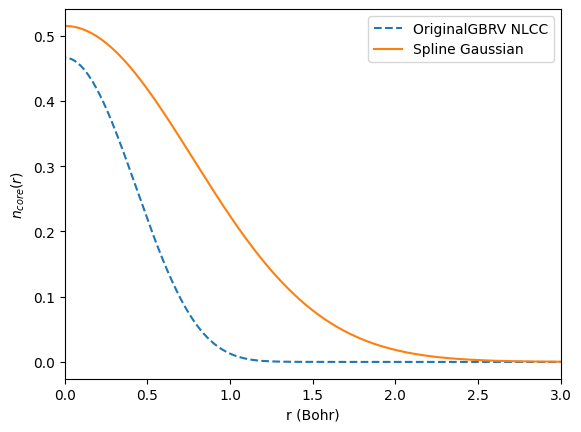

In [8]:
plt.plot(r_gbrv, core_density_gbrv_r, '--', label='OriginalGBRV NLCC')
plt.plot(r_core, core_g, label='Spline Gaussian')
plt.ylabel(r'$n_{core}(r)$')
plt.xlabel('r (Bohr)')
plt.xlim(0,3)
plt.legend()

In [9]:
np.sum((core_g*r_gbrv))
integrand = core_g*r_gbrv**2 * 4 * np.pi
np.trapz(integrand, r_gbrv)

3.7703038956614807

In [10]:
import numpy as np
from scipy.integrate import simpson

def read_nlcc_from_upf(upf_filename):
    """
    Read NLCC (nonlinear core correction) data from a UPF file.
    Works for GBRV / QE UPF formats where PP_NLCC is floats directly.
    """
    with open(upf_filename, 'r') as f:
        lines = f.readlines()
    
    # Find the section <PP_NLCC>
    nlcc_start = None
    nlcc_end = None
    for i, line in enumerate(lines):
        if "<PP_NLCC>" in line:
            nlcc_start = i + 1
        if "</PP_NLCC>" in line:
            nlcc_end = i
            break
    if nlcc_start is None or nlcc_end is None:
        raise ValueError("No <PP_NLCC> block found.")

    # Read all the numbers between <PP_NLCC> and </PP_NLCC>
    nlcc_data = []
    for line in lines[nlcc_start:nlcc_end]:
        nlcc_data.extend([float(x) for x in line.split()])
    rho_core = np.array(nlcc_data)

    # Now find radial grid <PP_R>
    r_start = None
    r_end = None
    for i, line in enumerate(lines):
        if "<PP_R>" in line:
            r_start = i + 1
        if "</PP_R>" in line:
            r_end = i
            break
    if r_start is None or r_end is None:
        raise ValueError("No <PP_R> block found.")

    r_data = []
    for line in lines[r_start:r_end]:
        r_data.extend([float(x) for x in line.split()])
    r = np.array(r_data)

    # Now integrate to get total core charge
    integrand = 4 * np.pi * r**2 * rho_core
    total_core_electrons = simpson(integrand, x=r)

    return r, rho_core, total_core_electrons


In [11]:
r, rho_core, total_core_electrons = read_nlcc_from_upf('/projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF')

In [12]:
np.sum((core_density_gbrv_r*r_gbrv))
integrand = core_density_gbrv_r*r_gbrv**2 * 4 * np.pi
np.trapz(integrand, r_gbrv)

0.425310170921448

##### Save the pseudopotential with the NLCC

In [13]:
path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

key = 'Ag'
r = pseudo_ngbrv_ag.readpp.pp[key].r
vl = pseudo_ngbrv_ag.readpp.pp[key].v
zval = pseudo_ngbrv_ag.zval[key]

from dftpy.functional.pseudo.psp import PSP
engine = PSP(None)
engine.r = r
engine.v = vl
engine.info['atomicnum'] = 27
engine.info['fchrg'] = 1.0
engine.info['mmax'] = len(r)
engine._zval = zval
engine._core_density_grid = r
engine._core_density = core_g* 4*np.pi# 4 * np.pi for psp8 files
engine.write('Ag_nlcc_4_gbrv.psp8')

In [14]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_nlcc_4_gbrv.psp8'}

##### Read the saved pseudopotential with the NLCC

In [15]:
pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
pseudo_ngbrv_ag.local_PP()
core_density_nlcc = pseudo_ngbrv_ag.core_density ### Get the core density on a grid (in this case the grid for the FCC Ag)

v_ngbrv_ag = pseudo_ngbrv_ag.readpp.pp['Ag'].v
r_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].r

core_density_ngbrv = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density ### Get the core density on r
r_core = pseudo_ngbrv_ag.readpp.pp['Ag'].core_density_grid

setting key: Ag -> .//Ag_nlcc_4_gbrv.psp8


##### Visualize the core density from GBRV and NGBRV as well as the LPP

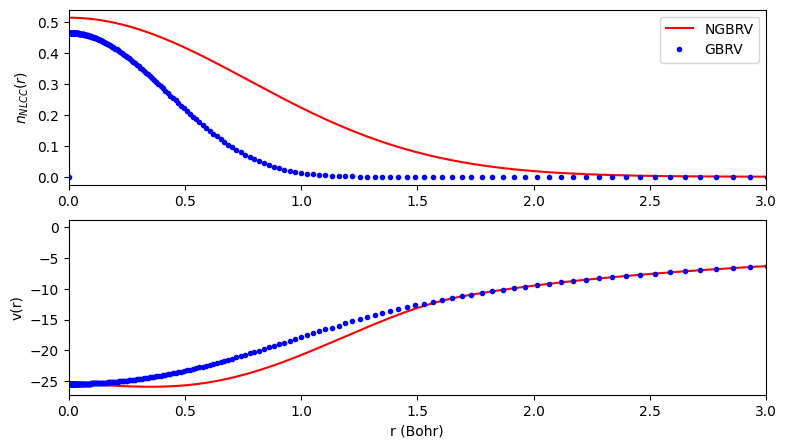

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9,5))
axs[0].plot(r_ngbrv, (core_density_ngbrv).ravel(), 'r', label='NGBRV')
axs[0].plot(r_gbrv, core_density_gbrv_r.ravel(), 'b.', label='GBRV')

axs[1].plot(r_ngbrv, (v_ngbrv_ag).ravel(), 'r')
axs[1].plot(r_gbrv, v_gbrv_ag.ravel(), 'b.')

axs[0].set_ylabel(r'$n_{NLCC}(r)$')
axs[1].set_ylabel('v(r)')
axs[1].set_xlabel('r (Bohr)')

axs[0].set_xlim(0.0,3)
axs[1].set_xlim(0.0,3)
axs[0].legend()

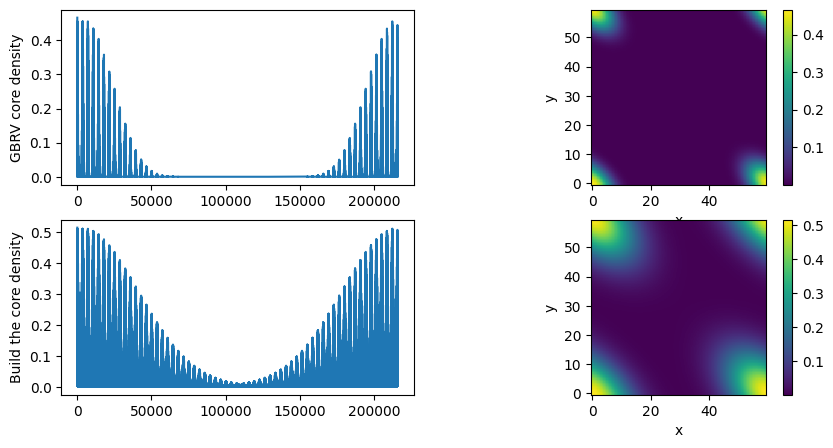

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(core_density_gbrv.ravel())

z_slice = core_density_gbrv.shape[2] // 2
z_slice = 0
im1 = axs[0,1].imshow(core_density_gbrv[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im1, ax=axs[0,1], orientation='vertical')

axs[0,1].set_xlabel("x")
axs[0,1].set_ylabel("y")
axs[0,0].set_ylabel("GBRV core density")
axs[1,0].plot((core_density_nlcc).ravel())
im2=axs[1,1].imshow((core_density_nlcc)[:, :, z_slice], origin='lower', cmap='viridis')
fig.colorbar(im2, ax=axs[1,1], orientation='vertical')

# axs[1].colorbar(label="ρ_core")
# axs[1,1].set_title("Midplane Slice of NLCC Field (z = center)")
axs[1,1].set_xlabel("x")
axs[1,1].set_ylabel("y")
axs[1,0].set_ylabel("Build the core density")
plt.show()

# ENergy surface

In [18]:
def get_energy(KE, ions, PSEUDO):
    rho_ini = DirectField(grid=grid)
    rho_ini[:] = ions.get_ncharges()/ions.cell.volume
    evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
    opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                       optimization_method = 'CG')
    rho = opt.optimize_rho(guess_rho=rho_ini)
    forces = evaluator.get_forces(rho=rho)
    v = KE(rho).potential
    return evaluator.Energy(rho=rho, ions=ions), rho, forces, evaluator

In [19]:
HARTREE = Functional(type='HARTREE')
opt_options = {'econv' : 1e-6}

#### Analysis in reciprocal space

In [20]:
grid = core_density_nlcc.grid
grid = DirectGrid(lattice=ions_ag.cell, nr=nr)
pseudo_ngbrv_ag = LocalPseudo(grid = grid, ions=ions_ag, PP_list=PP_list_ngbrv_ag)
core_density = pseudo_ngbrv_ag.core_density

reciprocal_grid = grid.get_reciprocal()
g = reciprocal_grid.g
rhog = core_density.fft()
new_rhog = ReciprocalField(grid=grid, griddata_3d=rhog[:])

setting key: Ag -> .//Ag_nlcc_4_gbrv.psp8


In [21]:
new_rhor = new_rhog.ifft()

Text(0.5, 1.0, 'rho_core in reciprocal space')

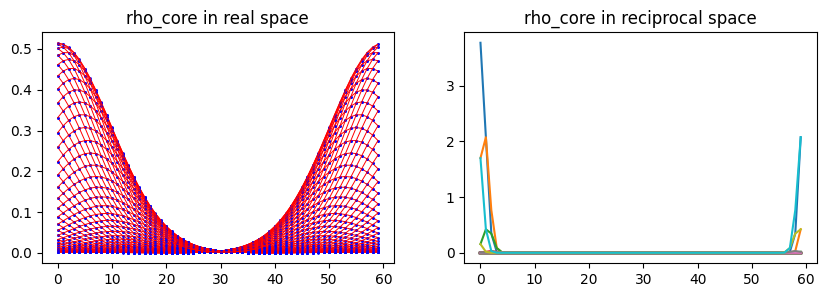

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

for i in np.arange(0,len(g[0][0])):
    axs[0].plot(core_density[0,i,:].ravel(), 'b.', markersize=1.9)
    axs[0].plot(new_rhor[0,i,:].ravel(), 'r', lw=0.7)
    axs[1].plot(rhog[i,i,:].ravel(), label='fft rhoc')

axs[0].set_title('rho_core in real space')
axs[1].set_title('rho_core in reciprocal space')


### Analysis of analytical vs numerical forces and energy vs distance

In [29]:
import numpy as np
from dftpy.functional import TotalFunctional
from dftpy.optimization import Optimization
from copy import deepcopy

def compute_numerical_forces(ions, energy_evaluator, dr=1e-2):
    n_atoms = ions.nat
    forces = np.zeros((n_atoms, 3))
    positions0 = ions.positions.copy()

    for i in range(n_atoms):
        for j in range(3):
            ions_plus = deepcopy(ions)
            ions_plus.positions[i, j] += dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_plus, PP_list=PP_list_ngbrv_ag)
            eval_plus = TotalFunctional(KE=energy_evaluator.KE,
                                         XC=energy_evaluator.XC,
                                         HARTREE=energy_evaluator.HARTREE,
                                         PSEUDO=PSEUDO)
            eval_plus.ions = ions_plus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_plus.get_ncharges()/ions_plus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_plus = opt.optimize_rho(guess_rho=rho_ini)
            E_plus = eval_plus.Energy(rho_plus)
            
            ions_minus = deepcopy(ions)
            ions_minus.positions[i, j] -= dr
            PSEUDO = LocalPseudo(grid = grid, ions=ions_minus, PP_list=PP_list_ngbrv_ag)
            eval_minus = TotalFunctional(KE=energy_evaluator.KE,
                                          XC=energy_evaluator.XC,
                                          HARTREE=energy_evaluator.HARTREE,
                                          PSEUDO=PSEUDO)
            eval_minus.ions = ions_minus
            rho_ini = DirectField(grid=grid)
            rho_ini[:] = ions_minus.get_ncharges()/ions_minus.cell.volume
            opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options,
                   optimization_method = 'CG')
            rho_minus = opt.optimize_rho(guess_rho=rho_ini)
            E_minus = eval_minus.Energy(rho_minus)
            E_minus = eval_minus.Energy(rho_minus)

            forces[i, j] = -(E_plus - E_minus) / (2 * dr)

    ions.positions[:] = positions0
    return forces

def calc_force_cc(potential = None, rhod = None, ions = None):
    """Calculate the correction forces

    Parameters
    ----------
    potential : field
        Potential in real space.
    rhod :
        density of each element in reciprocal space
    """
    #
    # if rhod is None : rhod = self.vlines_core
    if ions is None : ions = ions
    grid = potential.grid
    #
    reciprocal_grid = grid.get_reciprocal()
    forces = np.zeros((ions.nat, 3))
    mask = reciprocal_grid.mask
    g = reciprocal_grid.g

    if potential.rank == 2 : potential = 0.5*(potential[0]+potential[1])
    potg = potential.fft()

    for key in sorted(ions.zval):
            rhocg = rhod
            if rhocg is None : continue
            for i in range(ions.nat):
                if ions.symbols[i] == key:
                    strf = ions.istrf(reciprocal_grid, i)
                    den = (potg[mask] * rhocg[mask] * strf[mask]).imag
                    for j in range(3):
                        forces[i, j] = np.einsum("i, i->", g[j][mask], den)
    forces *= 2.0 / grid.volume
    return forces


#### NGBRV0.2 with NLCC

In [30]:
path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_nlcc_4_gbrv.psp8'}

In [31]:
from ase import Atoms
E_ngbrv_f = []
F_ngbrv_f = []
F_ngbrv_f_ke = []
F_ngbrv_f_xc = []
F_num = []
V = []
# nr = [60,60,60]#
opt_options = {'econv' : 1e-4}
# alats_n = np.linspace(0, 1.5, 10)
alats = [1.15, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 10
for alat in alats:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, ecut=50)
    print(grid.spacings[0], grid.nr)
    PSEUDO_nGBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv_ag)
    core = PSEUDO_nGBRV.core_density
    v_lines = PSEUDO_nGBRV.vlines_core['Ag']
    # PSEUDO_nGBRV.local_PP()
    XC = Functional(type='XC',name='LDA', core_density=core, pseudo=PSEUDO_nGBRV, libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core, pseudo=PSEUDO_nGBRV)
    ene_ngbrv, rho, forces, evaluator = get_energy(KE, ions, PSEUDO_nGBRV)
    forces_ke = calc_force_cc(potential=KE(rho).potential, rhod=v_lines, ions=ions)
    forces_xc = calc_force_cc(potential=XC(rho).potential, rhod=v_lines, ions=ions)
    forces_num = compute_numerical_forces(ions, evaluator)
    F_num.append(forces_num)
    F_ngbrv_f.append(forces)
    F_ngbrv_f_ke.append(forces_ke)
    F_ngbrv_f_xc.append(forces_xc)
    E_ngbrv_f.append(ene_ngbrv)

0.3149543543061547 [60 60 60]
setting key: Ag -> .//Ag_nlcc_4_gbrv.psp8
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.001749105544E+01      6.001749E+01    1.791442E+02    1       1       1.342607E-01    
1       -2.382540426580E+02     -2.982715E+02   5.896449E+02    1       4       3.496234E-01    
2       -2.560418926217E+02     -1.778785E+01   7.715767E+02    1       1       4.087851E-01    
3       -2.908065757689E+02     -3.476468E+01   8.505258E+01    1       2       5.168149E-01    
4       -2.947916139958E+02     -3.985038E+00   4.019823E+01    1       3       6.508660E-01    
5       -2.986572548976E+02     -3.865641E+00   9.993250E+00    1       3       7.817943E-01    
6       -2.999281577329E+02     -1.270903E+00   8.282802E+00    1       3       9.239144E-01    
7       -3.007984612477E+02     -8.703035E-01   5.486853E+00    1       2       1.032275E+00    
8       -3.013467356817E+02     -5.482744E-01   2.42155

In [33]:
atom1_x_num = [F_num[0][0][0], F_num[1][0][0], F_num[2][0][0], F_num[3][0][0]]
atom1_x_anl = [F_ngbrv_f[0][0][0], F_ngbrv_f[1][0][0], F_ngbrv_f[2][0][0], F_ngbrv_f[3][0][0]]

atom2_x_num = [F_num[0][1][0], F_num[1][1][0], F_num[2][1][0], F_num[3][1][0]]
atom2_x_anl = [F_ngbrv_f[0][1][0], F_ngbrv_f[1][1][0], F_ngbrv_f[2][1][0], F_ngbrv_f[3][1][0]]

atom1_y_num = [F_num[0][0][1], F_num[1][0][1], F_num[2][0][1], F_num[3][0][1]]
atom1_y_anl = [F_ngbrv_f[0][0][1], F_ngbrv_f[1][0][1], F_ngbrv_f[2][0][1], F_ngbrv_f[3][0][1]]

atom2_y_num = [F_num[0][1][1], F_num[1][1][1], F_num[2][1][1], F_num[3][1][1]]
atom2_y_anl = [F_ngbrv_f[0][1][1], F_ngbrv_f[1][1][1], F_ngbrv_f[2][1][1], F_ngbrv_f[3][1][1]]

atom1_z_num = [F_num[0][0][2], F_num[1][0][2], F_num[2][0][2], F_num[3][0][2]]
atom1_z_anl = [F_ngbrv_f[0][0][2], F_ngbrv_f[1][0][2], F_ngbrv_f[2][0][2], F_ngbrv_f[3][0][2]]

atom2_z_num = [F_num[0][1][2], F_num[1][1][2], F_num[2][1][2], F_num[3][1][2]]
atom2_z_anl = [F_ngbrv_f[0][1][2], F_ngbrv_f[1][1][2], F_ngbrv_f[2][1][2], F_ngbrv_f[3][1][2]]

Text(0.5, 1.0, 'Total forces')

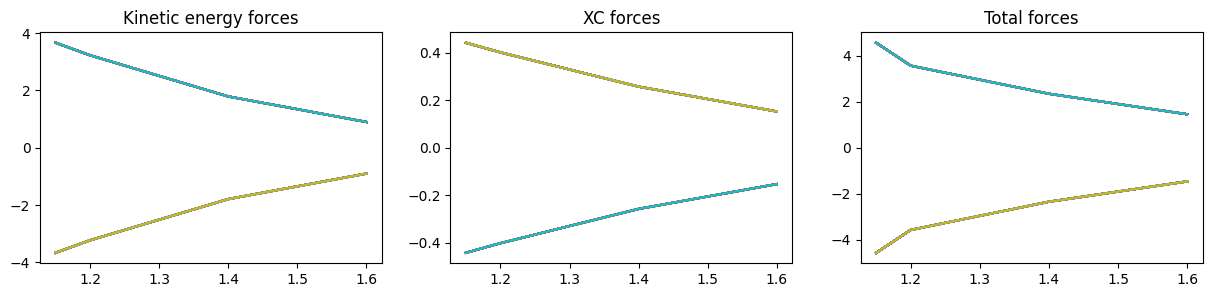

In [34]:
atom1_x_ke = [F_ngbrv_f_ke[0][0][0], F_ngbrv_f_ke[1][0][0], F_ngbrv_f_ke[2][0][0], F_ngbrv_f_ke[3][0][0]]

atom2_x_ke = [F_ngbrv_f_ke[0][1][0], F_ngbrv_f_ke[1][1][0], F_ngbrv_f_ke[2][1][0], F_ngbrv_f_ke[3][1][0]]

atom1_x_xc = [F_ngbrv_f_xc[0][0][0], F_ngbrv_f_xc[1][0][0], F_ngbrv_f_xc[2][0][0], F_ngbrv_f_xc[3][0][0]]

atom2_x_xc = [F_ngbrv_f_xc[0][1][0], F_ngbrv_f_xc[1][1][0], F_ngbrv_f_xc[2][1][0], F_ngbrv_f_xc[3][1][0]]

import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for i in np.arange(len(rho[0][0])-10):
    axs[0].plot(alats,atom1_x_ke, label='KE')
    axs[0].plot(alats,atom2_x_ke, label='KE')
    axs[1].plot(alats,atom1_x_xc, label='XC')
    axs[1].plot(alats,atom2_x_xc, label='XC')
    axs[2].plot(alats,atom1_x_anl)
    axs[2].plot(alats,atom2_x_anl)

axs[0].set_title('Kinetic energy forces')
axs[1].set_title('XC forces')
axs[2].set_title('Total forces')
# plt.legend()

In [35]:
pseudo_pot_nlcc = PSEUDO_nGBRV(rho).potential.fft()
kin_pot_nlcc = KE(rho).potential.fft()
xc_pot_nlcc = XC(rho).potential.fft()

Text(0.5, 1.0, 'XC potential in reciprocal space')

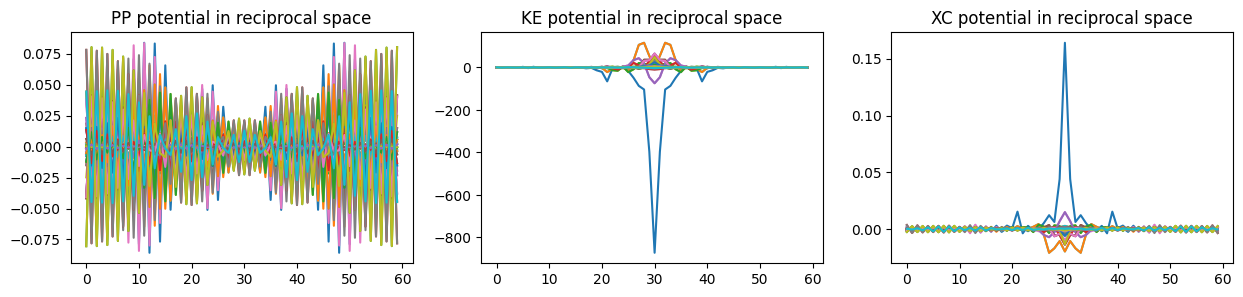

In [36]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))

for i in np.arange(len(rho[0][0])-10):
    axs[0].plot(pseudo_pot_nlcc[i,30,:].ravel(), label='PP')
    axs[1].plot(kin_pot_nlcc[i,30,:].ravel(), label='KE')
    axs[2].plot(xc_pot_nlcc[i,30,:].ravel(), label='XC')
axs[0].set_title('PP potential in reciprocal space')
axs[1].set_title('KE potential in reciprocal space')
axs[2].set_title('XC potential in reciprocal space')

/tmp/ipykernel_51856/344283520.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,1].legend()


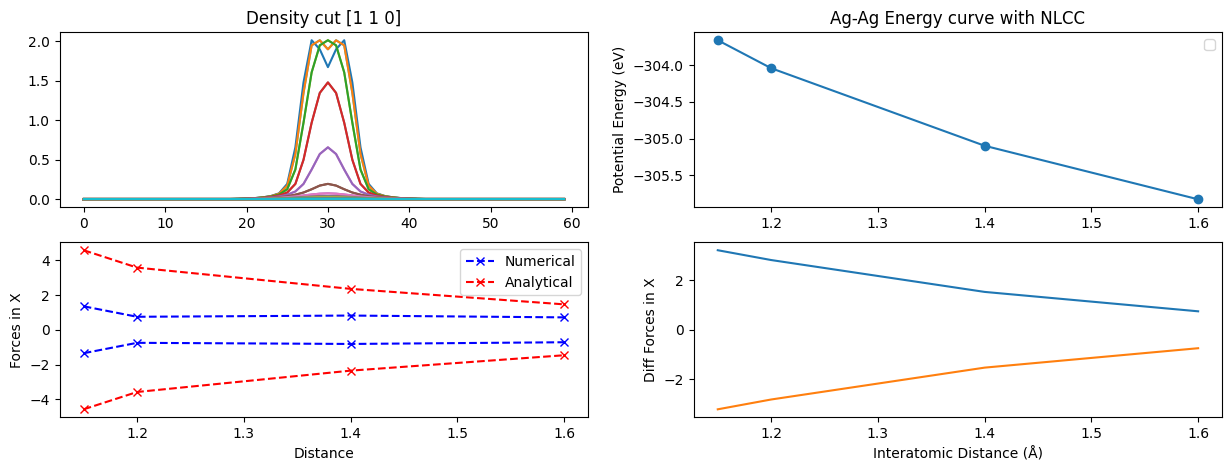

In [37]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[30,i,:].ravel())
    
axs[0,1].scatter(alats[0:],  np.asarray(E_ngbrv_f[0:]))
axs[0,1].plot(alats[0:],  np.asarray(E_ngbrv_f[0:]))

axs[1,0].plot(alats[0:], atom1_x_num[0:], '--', label='Numerical', marker='x', color='b')
axs[1,0].plot(alats[0:], atom1_x_anl[0:], '--', label='Analytical', marker='x', color='r')
axs[1,0].set_ylabel('Forces in X')
axs[1,0].set_xlabel('Distance')
axs[1,0].plot(alats[0:], np.asarray(atom2_x_num[0:]), '--', marker='x', color='b')
axs[1,0].plot(alats[0:], atom2_x_anl[0:], '--',  marker='x', color='r')

axs[1,1].plot(alats, np.asarray(atom1_x_num)-np.asarray(atom1_x_anl))
axs[1,1].plot(alats, np.asarray(atom2_x_num)-np.asarray(atom2_x_anl))
axs[1,1].set_ylabel('Diff Forces in X')
axs[1,1].set_xlabel('Distance')

plt.xlabel('Interatomic Distance (Å)')
axs[0,1].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[0,1].set_title('Ag-Ag Energy curve with NLCC')
# axs[1].set_ylim(-316,-314)


axs[0,1].legend()
axs[1,0].legend()
plt.show()

### Plot total forces on each direction X, Y and Z

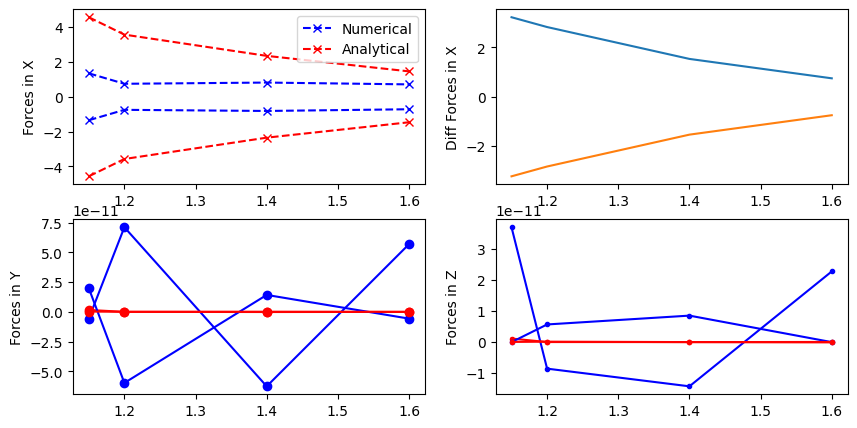

In [39]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
axs[0,0].plot(alats, atom1_x_num, '--', label='Numerical', marker='x', color='b')
axs[0,0].plot(alats, atom1_x_anl, '--', label='Analytical', marker='x', color='r')
axs[0,0].set_ylabel('Forces in X')
axs[0,0].plot(alats, atom2_x_num, '--', marker='x', color='b')
axs[0,0].plot(alats, atom2_x_anl, '--',  marker='x', color='r')

axs[0,1].plot(alats, np.asarray(atom1_x_num)-np.asarray(atom1_x_anl))
axs[0,1].plot(alats, np.asarray(atom2_x_num)-np.asarray(atom2_x_anl))
axs[0,1].set_ylabel('Diff Forces in X')

axs[1,0].plot(alats, atom1_y_num, marker='o', color='b')
axs[1,0].plot(alats, atom1_y_anl,  marker='o', color='r')
axs[1,0].plot(alats, atom2_y_num, marker='o', color='b')
axs[1,0].plot(alats, atom2_y_anl,  marker='o', color='r')
axs[1,0].set_ylabel('Forces in Y')
axs[1,1].plot(alats, atom1_z_num, '.-',  color='b')
axs[1,1].plot(alats, atom1_z_anl, '.-',  color='r')

axs[1,1].plot(alats, atom2_z_num, '.-',  color='b')
axs[1,1].plot(alats, atom2_z_anl, '.-',  color='r')
axs[1,1].set_ylabel('Forces in Z')

axs[0,0].legend()

#### NGBRV0.2 without NLCC

In [29]:
path_ngbrv = '/projectsn/mp1009_1/Valeria/NLPP/NPP_0.2/'
PP_list_ngbrv = {'Ag': path_ngbrv + '/Ag_gbrv_new.psp8'}

In [30]:
from ase import Atoms
E_Ngbrv = []
F_Ngbrv = []
F_Nnum = []
V = []
nr = [60,60,60] 
opt_options = {'econv' : 1e-4}
alats = [1.0, 1.2, 1.4, 1.6]#, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]#, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]
L = 15
for i, alat in enumerate(alats):
    print('STEP: ', i)
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    
    
    PSEUDO_nGBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_ngbrv)
    core = PSEUDO_nGBRV.core_density
    XC = Functional(type='XC',name='LDA', core_density=core, pseudo=PSEUDO_nGBRV, libxc=False)
    KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core)
    ene_ngbrv, rho, forces, evaluator = get_energy(KE, ions, PSEUDO_nGBRV)
    # forces_num = compute_numerical_forces(ions, evaluator)
    
    # F_Nnum.append(forces_num)
    F_Ngbrv.append(forces)
    E_Ngbrv.append(ene_ngbrv)

STEP:  0
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/NPP_0.2//Ag_gbrv_new.psp8
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.160624365510E+02      1.160624E+02    9.485434E+01    1       1       1.021507E-01    
1       -2.043086997934E+02     -3.203711E+02   1.224302E+03    1       4       2.719479E-01    
2       -2.973923075424E+02     -9.308361E+01   7.947426E+02    1       1       3.216803E-01    
3       -3.251072605037E+02     -2.771495E+01   4.910843E+01    1       3       4.516733E-01    
4       -3.291705648053E+02     -4.063304E+00   1.135221E+01    1       2       5.474801E-01    
5       -3.309332901164E+02     -1.762725E+00   8.832462E+00    1       2       6.363051E-01    
6       -3.318549212360E+02     -9.216311E-01   5.437805E+00    1       2       7.245941E-01    
7       -3.324366685200E+02     -5.817473E-01   2.086768E+00    1       2       8.155017E-01    
8       -3.326638543677E+02     -2.27185

In [38]:
pseudo_pot = PSEUDO_nGBRV(rho+core).potential
kin_pot = KE(rho+core).potential
xc_pot = XC(rho+core).potential

In [36]:
atom1_x_num_N = [F_Nnum[0][0][0], F_Nnum[1][0][0], F_Nnum[2][0][0], F_Nnum[3][0][0]]
atom1_x_anl_N = [F_Ngbrv[0][0][0], F_Ngbrv[1][0][0], F_Ngbrv[2][0][0], F_Ngbrv[3][0][0]]

atom2_x_num_N = [F_Nnum[0][1][0], F_Nnum[1][1][0], F_Nnum[2][1][0], F_Nnum[3][1][0]]
atom2_x_anl_N = [F_Ngbrv[0][1][0], F_Ngbrv[1][1][0], F_Ngbrv[2][1][0], F_Ngbrv[3][1][0]]

atom1_y_num_N = [F_Nnum[0][0][1], F_Nnum[1][0][1], F_Nnum[2][0][1], F_Nnum[3][0][1]]
atom1_y_anl_N = [F_Ngbrv[0][0][1], F_Ngbrv[1][0][1], F_Ngbrv[2][0][1], F_Ngbrv[3][0][1]]

atom2_y_num_N = [F_Nnum[0][1][1], F_Nnum[1][1][1], F_Nnum[2][1][1], F_Nnum[3][1][1]]
atom2_y_anl_N = [F_Ngbrv[0][1][1], F_Ngbrv[1][1][1], F_Ngbrv[2][1][1], F_Ngbrv[3][1][1]]

atom1_z_num_N = [F_Nnum[0][0][2], F_Nnum[1][0][2], F_Nnum[2][0][2], F_Nnum[3][0][2]]
atom1_z_anl_N = [F_Ngbrv[0][0][2], F_Ngbrv[1][0][2], F_Ngbrv[2][0][2], F_Ngbrv[3][0][2]]

atom2_z_num_N = [F_Nnum[0][1][2], F_Nnum[1][1][2], F_Nnum[2][1][2], F_Nnum[3][1][2]]
atom2_z_anl_N = [F_Ngbrv[0][1][2], F_Ngbrv[1][1][2], F_Ngbrv[2][1][2], F_Ngbrv[3][1][2]]

In [46]:
np.asarray(atom2_x_num_N) - np.asarray(atom2_x_anl_N)

array([3.85749073e-03, 1.18057629e-03, 1.43145922e-04, 4.28589439e-05])

In [45]:
np.asarray(atom1_x_num_N) - np.asarray(atom1_x_anl_N)

array([-3.85749077e-03, -1.17596328e-03, -1.45003091e-04, -3.72187167e-05])

/tmp/ipykernel_59933/3699099060.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0,1].legend()


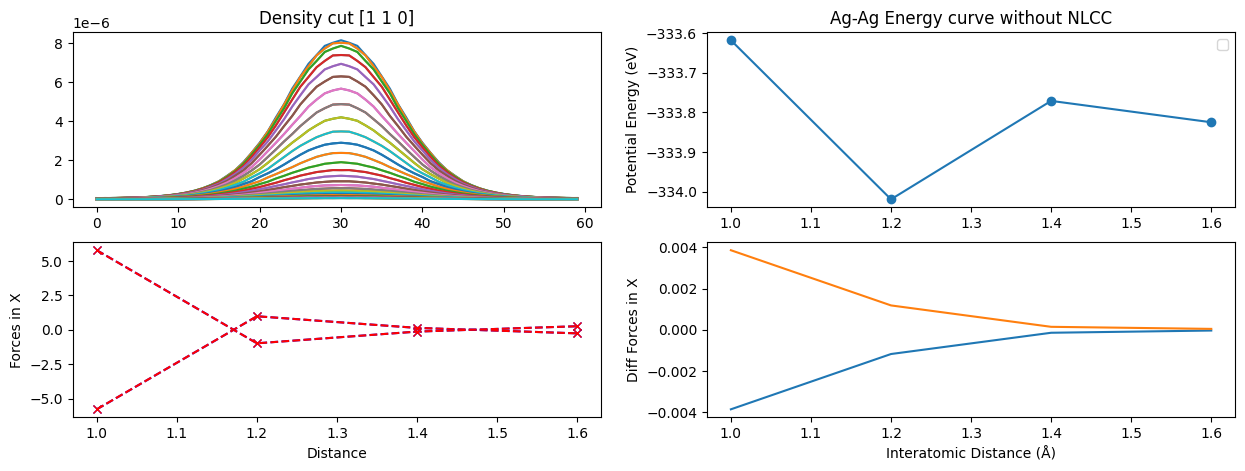

In [43]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5))

for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[0,i,:].ravel())
    
axs[0,1].scatter(alats[0:],  np.asarray(E_Ngbrv[0:]))
axs[0,1].plot(alats[0:],  np.asarray(E_Ngbrv[0:]))

axs[1,0].plot(alats[0:], atom1_x_num_N[0:], '--', label='Numerical', marker='x', color='b')
axs[1,0].plot(alats[0:], atom1_x_anl_N[0:], '--', label='Analytical', marker='x', color='r')
axs[1,0].set_ylabel('Forces in X')
axs[1,0].set_xlabel('Distance')
axs[1,0].plot(alats[0:], atom2_x_num_N[0:], '--', marker='x', color='b')
axs[1,0].plot(alats[0:], atom2_x_anl_N[0:], '--',  marker='x', color='r')

axs[1,1].plot(alats, np.asarray(atom1_x_num_N)-np.asarray(atom1_x_anl_N))
axs[1,1].plot(alats, np.asarray(atom2_x_num_N)-np.asarray(atom2_x_anl_N))
axs[1,1].set_ylabel('Diff Forces in X')
axs[1,1].set_xlabel('Distance')

plt.xlabel('Interatomic Distance (Å)')
axs[0,1].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[0,1].set_title('Ag-Ag Energy curve without NLCC')
# axs[1].set_ylim(-316,-314)


axs[0,1].legend()
plt.show()

####  GBRV

In [41]:
path_gbrv = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
PP_list_gbrv = {'Ag': path_gbrv+'ag_lda_v1.4.uspp.F.UPF'}

In [45]:
from ase import Atoms
E_gbrv = []
F_gbrv = []
V = []
nr = [10,10,10]#
opt_options = {'econv' : 1e-5}
alats_n = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9, 1.0, 1.2, 1.4]

L = 5
for alat in alats_n:
    atoms = Atoms('Ag2', positions=[[L/2, L/2, L/2], [alat+L/2, L/2, L/2]])
    atoms.set_cell([L, L, L])
    ions = Ions.from_ase(atoms)
    grid = DirectGrid(lattice=ions.cell, nr=nr)
    print(grid.spacings[0], grid.nr)
    PSEUDO_GBRV = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list_gbrv)
    core = PSEUDO_GBRV.core_density
    if PSEUDO_GBRV.vlines_core['Ag'] is None: print('Not core') 
    PSEUDO_GBRV.local_PP()
    XC = Functional(type='XC',name='LDA', core_density=core, libxc=False)
    KE = Functional(type='KEDF', name='TFvW',core_density=core,  y=0.2)
    ene_ngbrv, rho, forces, evaltr= get_energy(KE, ions, PSEUDO_GBRV)
    F_gbrv.append(forces[:,0])
    E_gbrv.append(ene_ngbrv)

0.9448630629184642 [10 10 10]
setting key: Ag -> /projectsn/mp1009_1/Valeria/NLPP/PP/ag_lda_v1.4.uspp.F.UPF
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -8.180731234576E+01     -8.180731E+01   5.815881E+02    1       1       3.605795E-02    
1       -4.185274898273E+02     -3.367202E+02   1.090695E+02    1       2       6.462932E-02    
2       -4.234485464999E+02     -4.921057E+00   1.105419E+01    1       3       7.479191E-02    
3       -4.242636816879E+02     -8.151352E-01   1.644607E+00    1       2       8.552742E-02    
4       -4.244452521819E+02     -1.815705E-01   9.038334E-01    1       3       9.511375E-02    
5       -4.245057070489E+02     -6.045487E-02   3.749484E-01    1       3       1.061168E-01    
6       -4.246018640929E+02     -9.615704E-02   5.506591E-01    1       3       1.120121E-01    
7       -4.246745384607E+02     -7.267437E-02   5.442444E-01    1       3       1.176174E-01    
8       -4.24733532

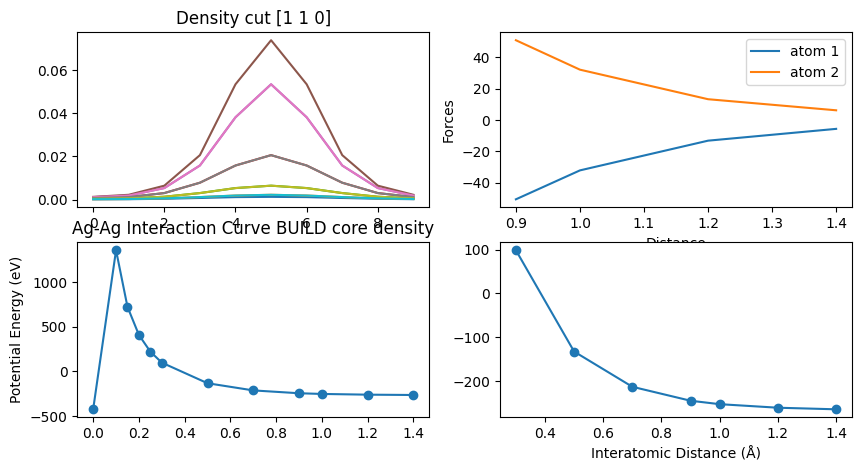

In [52]:
atom1_g = np.asarray(F_gbrv)[:,0]
atom2_g = np.asarray(F_gbrv)[:,1]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
alats = np.linspace(0, 1.5, 10)
for i in np.arange(len(rho[0][0])):
    axs[0,0].plot((rho)[0,i,:].ravel())
axs[1,0].scatter(alats_n[0:],  np.asarray(E_gbrv[0:]))
axs[1,0].plot(alats_n[0:],  np.asarray(E_gbrv[0:]))
axs[1,1].scatter(alats_n[5:],  np.asarray(E_gbrv[5:]))
axs[1,1].plot(alats_n[5:],  np.asarray(E_gbrv[5:]))
plt.xlabel('Interatomic Distance (Å)')
axs[1,0].set_ylabel('Potential Energy (eV)')
axs[0,0].set_title('Density cut [1 1 0]')
axs[1,0].set_title('Ag-Ag Interaction Curve BUILD core density')
# axs[1].set_ylim(-316,-314)
axs[0,1].plot(alats_n[8:], atom1_g[8:].ravel(), label='atom 1')
axs[0,1].plot(alats_n[8:], atom2_g[8:].ravel(), label='atom 2')
axs[0,1].set_ylabel('Forces')
axs[0,1].set_xlabel('Distance')
axs[0,1].legend()
plt.show()

#### Test on first steps pf MD at 300 K of Ag FCC 

In [50]:
from ase.lattice.cubic import FaceCenteredCubic

from ase import Atoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
import numpy as np
import matplotlib.pyplot as plt
from dftpy.api.api4ase import DFTpyCalculator

path_ngbrv = './'
PP_list_ngbrv_ag = {'Ag': path_ngbrv + '/Ag_nlcc_4_gbrv.psp8'}
size = 3
a = 4.259663119760805 #4.24068463425528
T = 300  # Kelvin
atoms = FaceCenteredCubic(
    directions=[[1, 0, 0], [0, 1, 0], [0, 0, 1]], latticeconstant=a, symbol="Ag", size=(size, size, size), pbc=True
)
# Give it a small random thermal kick (e.g., 50 K)
MaxwellBoltzmannDistribution(atoms, temperature_K=50)

ions = Ions.from_ase(atoms)
grid = DirectGrid(ecut=30, lattice=ions.cell, full=False)


PSEUDO = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list_ngbrv_ag)
core = PSEUDO.core_density
PSEUDO.local_PP()
if PSEUDO.vlines_core['Ag'] is None: print('Not core')
KE = Functional(type='KEDF', name='TFvW', y=0.2, core_density=core)
XC = Functional(type='XC', name='LDA', core_density=core, libxc=False)
HARTREE = Functional(type='HARTREE')

funcDict = {'KE' :KE, 'XC' :XC, 'HARTREE' :HARTREE, 'PSEUDO' :PSEUDO}
EnergyEvaluator = TotalFunctional(**funcDict)

rho = DirectField(grid=grid)
rho[:] = ions.get_ncharges() / ions.cell.volume

opt_options = {'econv' : 1e-5, "maxiter": 600}
optimizer = Optimization(EnergyEvaluator=EnergyEvaluator, optimization_options = opt_options, optimization_method='CG')

calc = DFTpyCalculator(optimizer = optimizer, evaluator = EnergyEvaluator, rho = rho)

atoms.set_calculator(calc)



setting key: Ag -> .//Ag_nlcc_4_gbrv.psp8


/tmp/ipykernel_64280/1469792002.py:49: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)


In [51]:
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

dyn =Langevin(atoms, 1.0 * units.fs, temperature_K = T, friction = 0.1)

positions = []
energies = []
forces = []
step = 0
interval = 1
def log_atoms(a=atoms):
    positions.append(a.get_positions().copy())
    energies.append(a.get_potential_energy())
    forces.append(a.get_forces()[:,0])

def printenergy(a=atoms):
    global step, interval
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    sprint(
        "Step={:<8d} Epot={:.5f} Ekin={:.5f} T={:.3f} Etot={:.5f}".format(
            step, epot, ekin, ekin / (1.5 * units.kB), epot + ekin
        )
    )
    step += interval
dyn.attach(log_atoms, interval=1)
traj = Trajectory("md_test2.traj", "w", atoms)
dyn.attach(traj.write, interval=1)
dyn.attach(printenergy, interval=1)
# Run short 20-step test
dyn.run(50)

# Plot trajectory and energy
positions = np.array(positions)
energies = np.array(energies)



Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -9.957146470021E+03     -9.957146E+03   1.838669E+04    1       1       1.337478E-01    
1       -1.653608657508E+04     -6.578940E+03   2.027871E+03    1       1       1.707001E-01    
2       -1.668507914852E+04     -1.489926E+02   3.110952E+02    1       3       2.706132E-01    
3       -1.674295351393E+04     -5.787437E+01   1.392693E+02    1       3       3.689275E-01    
4       -1.677339716583E+04     -3.044365E+01   9.579076E+01    1       3       4.699063E-01    
5       -1.679475951061E+04     -2.136234E+01   8.286619E+01    1       3       5.681255E-01    
6       -1.680849453518E+04     -1.373502E+01   7.320395E+01    1       3       6.656406E-01    
7       -1.681766652398E+04     -9.171989E+00   3.648140E+01    1       3       7.611907E-01    
8       -1.682407609772E+04     -6.409574E+00   1.925868E+01    1       2       8.277569E-01    
9       -1.682695606350E+04   

KeyboardInterrupt: 

In [54]:
from ase.geometry.analysis import Analysis
analysis = Analysis(list(Trajectory('md_test2.traj')))
rdf = analysis.get_rdf(rmax=6.0, nbins=100, return_dists=True)
rdf = np.asarray(rdf).mean(axis=0)

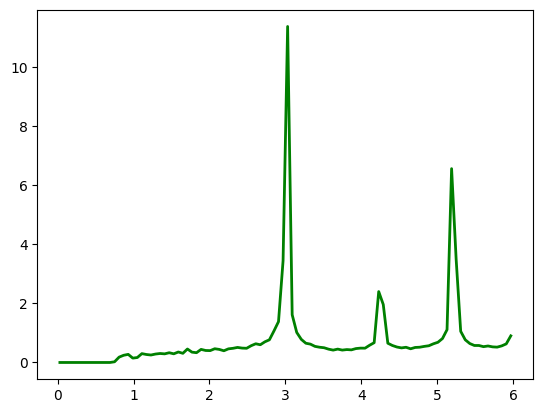

In [55]:
plt.plot(rdf[1], rdf[0], 'g', lw=2,label='NGBRV')


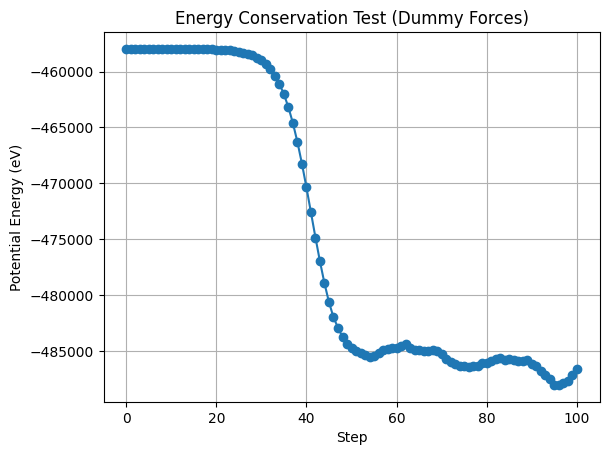

In [72]:
# Plot energy vs step
plt.figure()
plt.plot(energies, '-o')
plt.xlabel('Step')
plt.ylabel('Potential Energy (eV)')
plt.title('Energy Conservation Test (Dummy Forces)')
plt.grid(True)
plt.show()

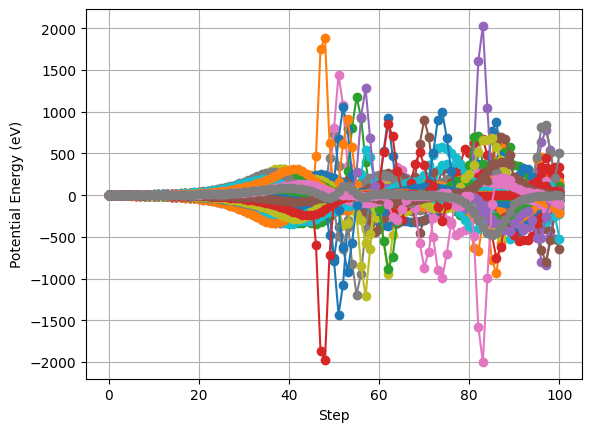

In [73]:
plt.figure()
plt.plot(forces, '-o')
plt.xlabel('Step')
plt.ylabel('Potential Energy (eV)')
# plt.title('Energy Conservation Test \')
plt.grid(True)
plt.show()